In [ ]:
## resource

# https://medium.com/@senthilnathangautham/colab-gcp-compute-how-to-link-them-together-98747e8d940e
# https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
# https://towardsdatascience.com/kaggle-vs-colab-faceoff-which-free-gpu-provider-is-tops-d4f0cd625029

In [ ]:
## install

# !pip install gym[atari]
# !pip install -U -q PyDrive

In [ ]:
## google drive connection

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
## setup

import gym

import numpy as np
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
import time
import pickle
from google.colab import files

# neural network
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow as tf
# print(tf.test.gpu_device_name())

# video
import imageio
# embed video to notebook
import base64
# interactive architecture for jupyter notebook
import IPython

# preprocessing
from skimage.color import rgb2gray
from skimage.transform import resize

In [ ]:
## hyperparameter

HEIGHT = 210
WIDTH = 160
CHANNEL = 3
N_OUT = 6
LEARNING_RATE_ADAM = 0.001 # learning rate in neural network optimizer
LEARNING_RATE_RMSPROP = 0.00025
GAMMA = 0.99 # discount factor
EPSILON_MIN = 0.1
BATCH_SIZE = 32
UPDATE_FREQ = 4
ACTION_REPEAT = 4
MODEL_PATH = 'model.h5'
FIGURE_PATH = 'dqn_reward.png'
REWARD_PATH = 'rewards.sav'
VIDEO_PATH = 'dqn_v1.mp4'


# in training to change
MAX_LENGTH_REPLAY = 20000 # too long harms RAM memory
TIME_STEP = 800 # too short doesn't enjoy entire game
EPISODES = 100
MONITOR_INTERVAL = 10
SAVE_MODEL_FREQ = 30
RESUME = True
EPSILON = 0.5
EPSILON_DECAY = 0.99
# EPSILON_DECAY = 0.999
EVAL_STEP = 800
EVAL_EPISODES = 3
# epsilon-greedy method in evaluation environment
# EPSILON_EVAL = 0.01 
EPSILON_EVAL = 0.1

# MODEL_LINK = 'https://drive.google.com/open?id=1Znfa8rqWpMQeaOmzDeaI4x8fSrWs_8Ih'
# fluff, id = MODEL_LINK.split('=')
# print(id)
# downloaded = drive.CreateFile({'id':id})
# downloaded.GetContentFile(MODEL_PATH)

action space Discrete(6)
meaning of action space ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space Box(210, 160, 3)


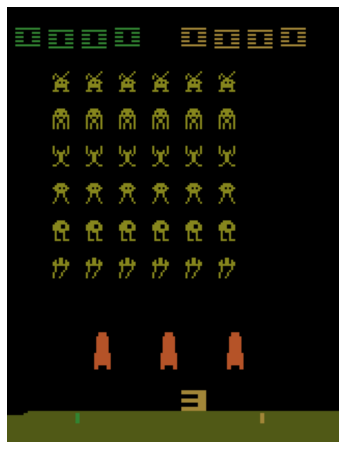

In [ ]:
## environment

env = gym.make('SpaceInvaders-v0')
env.reset()

# show spec
# Discrete(6) but action index includes 0, 1, 2, 3, 4, 5
print("action space", env.action_space)
print("meaning of action space", env.get_action_meanings())
print("observation space", env.observation_space)

# show environment
plt.figure(figsize = (8, 8))
plt.imshow(env.render('rgb_array'))
plt.axis('off')
plt.show()

In [ ]:
## experience replay

class Replay:
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = MAX_LENGTH_REPLAY

    def write(self, data):
        # if replay is full, delete the oldest (first list) and append the new
        if self.length >= self.max_length:
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1

    def read(self, batch_size):
        # at beginning buffer is almost empty, so batch is smaller than batch_size
        # random.sample is k sample from population without replacement
        return random.sample(population = self.buffer, k = min(batch_size, self.length))

In [ ]:
## network

class Network:
    def __init__(self, height, width, channel, n_out):
        self.height = height
        self.width = width
        self.channel = channel
        self.n_out = n_out

    def _build_model_1(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (self.height, self.width, self.channel,)))
        model.add(Conv2D(32, (3, 3), activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Flatten())
        model.add(Dense(32, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE_ADAM)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

    def _build_model_2(self):
        model = Sequential()
        model.add(Conv2D(16, (4, 4), padding = 'same', activation = 'relu', 
                         input_shape = (self.height, self.width, self.channel,),
                         strides = 3))
        model.add(MaxPooling2D(pool_size = (4, 4)))
        model.add(Flatten())
        model.add(Dense(16, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_ADAM)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

    def _build_deepmind_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides = 4, activation = 'relu',
                         input_shape = (84, 84, 4,)))
        model.add(Conv2D(64, (4, 4), strides = 2, activation = 'relu'))
        model.add(Conv2D(64, (3, 3), strides = 1, activation = 'relu'))
        model.add(Flatten())
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(self.n_out, activation = 'linear'))
        optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE_RMSPROP)
        model.compile(loss = 'mse', optimizer = optimizer)
        return model

In [ ]:
## agent

class Agent:
    def __init__(self):
        self.height = HEIGHT
        self.width = WIDTH
        self.channel = CHANNEL
        self.n_out = N_OUT
        self.total_reward = 0
        self.gamma = GAMMA # discount factor
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.batch_size = BATCH_SIZE
        self.replay_buffer = Replay()
        if RESUME:
            self.action_value_function = load_model(MODEL_PATH)
            self.target_action_value_function = load_model(MODEL_PATH)
            print('loaded model and resume training')
        else:
            self.action_value_function = Network(self.height, self.width, self.channel, self.n_out)._build_deepmind_model()
            self.target_action_value_function = Network(self.height, self.width, self.channel, self.n_out)._build_deepmind_model()
            print('initialize model')

    def gather_experience(self, last_state, action, reward, state):
        self.replay_buffer.write((last_state, action, reward, state))

    def set_total_reward(self, new_total):
        self.total_reward = new_total

    def gather_reward(self, reward):
        self.total_reward += reward

    def get_total_reward(self):
        return self.total_reward

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def clip_reward(self, reward):
        # sign function returns -1 if x < 0, 0 if x == 0, and 1 if x > 0
        return np.sign(reward)

    def choose_action(self, state):
        if np.random.rand() > self.epsilon:
            return np.argmax(self.action_value_function.predict(state)[0])
        else:
            return np.random.randint(low = 0, high = self.n_out - 1, size = None, dtype = 'int')

    def preprocess(self, state):
        # change color
        state = rgb2gray(state)
        # resize
        state = resize(state, (84, 84))
        # choose smallest type uint8 for efficiency
        # state = np.uint8(state)
        return state

    def initialize_stack(self, state):
        # axis = 2 stacks to 3rd dimention direction
        stack = np.stack((state, state, state, state), axis = 2)
        stack = np.reshape([stack], (-1, 84, 84, 4))
        return stack

    def stack_frames(self, state, stack):
        new_stack = np.reshape(state, (-1, 84, 84, 1))
        # stack order is always [t, t-1, t-2, t-3]
        # axis = 3 stacks to 4th dimention direction
        new_stack = np.append(new_stack, stack[:, :, :, :3], axis = 3)
        return new_stack

    def update_action_value_function(self):

        # checkpoint
        # now = time.time()
        
        batch = self.replay_buffer.read(self.batch_size)

        # checkpoint
        # prev = now; now = time.time(); print("sampled batch", round(now - prev, 2))

        n = len(batch)

        # extract batch
        last_states = np.concatenate(([b[0] for b in batch]), axis = 0)
        actions = np.array([b[1] for b in batch])
        rewards = np.array([b[2] for b in batch])
        states = np.concatenate(([b[3] for b in batch]), axis = 0)
        done_index = [np.any(s) == False for s in states]

        # checkpoint
        # prev = now; now = time.time(); print("extracted batch", round(now - prev, 2))
        # print("last_states.shape", last_states.shape, "states.shape", states.shape)

        # predictions
        q_hats_last = self.target_action_value_function.predict(last_states)
        q_hats = self.target_action_value_function.predict(states)
        # bellman equation
        ys = rewards + self.gamma * np.amax(q_hats, axis = 1)
        index = np.arange(0, len(q_hats_last))
        q_hats_last[index, actions] = ys

        # y_j = r_j if episode terminates at step j + 1
        if sum(done_index) > 0:
            q_hats_last[done_index, actions[done_index]] = rewards[done_index][0]

        # checkpoint
        # prev = now; now = time.time(); print("updated q", round(now - prev, 2))

        history = self.action_value_function.fit(last_states, q_hats_last, epochs = 1, verbose = 0)

        # checkpoint
        # prev = now; now = time.time(); print("updated model", round(now - prev, 2))

        # checkpoint
        # print("updated action value function")

        return history.history['loss'][0]

In [ ]:
print('EPISODE', EPISODES)
print('TIME_STEP', TIME_STEP)
print('ACTION_REPEAT', ACTION_REPEAT)
print('UPDATE_FREQ', UPDATE_FREQ)

EPISODE 100
TIME_STEP 800
ACTION_REPEAT 4
UPDATE_FREQ 4


In [ ]:
## training

# If update_q spends 0.05 seconds and time step is 200, 1 episode can finish with 10 seconds. Now update_q spends 0.2 seconds

start_time = time.time()
# now = time.time()

agent = Agent()
ep_rewards = []
loss = False
losses = []

for ep in range(EPISODES):
    
    # initialize state
    last_state = env.reset()
    last_state = agent.preprocess(last_state)
    last_state = agent.initialize_stack(last_state)

    # initialize total reward
    agent.set_total_reward(0)

    for t in range(TIME_STEP):

        # choose action
        if t == 0:
            action = agent.choose_action(last_state)
        # action repeat (???)
        elif t % ACTION_REPEAT == 0:
            action = agent.choose_action(last_state)

        # observe next state
        state, reward, done, info = env.step(action)

        # preprocess & stack frames
        state = agent.preprocess(state)
        state = agent.stack_frames(state, last_state)

        # if next state terminal, update next state as black image
        if done == True:
            state = np.zeros((1, 84, 84, 4))

        # clip reward from deepmind, "limits the scale of the error derivatives"
        reward = agent.clip_reward(reward)

        # accumulate rewards within the episode
        agent.gather_reward(reward)
        
        # append experience to buffer
        agent.gather_experience(last_state, action, reward, state)

        # train model and get current loss
        loss = agent.update_action_value_function()

        # update frequency of target network parameter theta_bar
        if t % UPDATE_FREQ == 0:
            # agent.target_action_value_function = agent.action_value_function
            agent.target_action_value_function.set_weights(agent.action_value_function.get_weights())

        # next state to be current state
        last_state = state

        # save total reward within one episode to list of total rewards
        if done == True:
            ep_rewards.append(agent.get_total_reward())
            break

    if done == False:
        ep_rewards.append(agent.get_total_reward())

    if loss:
        losses.append(loss)

    agent.decay_epsilon()

    if ep != 0 and ep % SAVE_MODEL_FREQ == 0:
        agent.action_value_function.save(MODEL_PATH)
        print("saved model")

        uploaded = drive.CreateFile({'title': MODEL_PATH})
        uploaded.SetContentFile(MODEL_PATH)
        uploaded.Upload()
        print("uploaded model to drive")

    # monitoring
    if ep % MONITOR_INTERVAL == 0:
        print("episode:{}, reward:{}, epsilon:{}, buffer length: {}, time:{}".format(ep, 
                                                                  agent.get_total_reward(),
                                                                  np.round(agent.epsilon, decimals = 5),
                                                                  len(agent.replay_buffer.buffer),
                                                                  np.round(time.time() - start_time, decimals = 0)))
        
agent.action_value_function.save(MODEL_PATH)
print("saved model")

uploaded = drive.CreateFile({'title': MODEL_PATH})
uploaded.SetContentFile(MODEL_PATH)
uploaded.Upload()
print("uploaded model to drive")

episode = range(0, EPISODES, 1)
plt.plot(episode, ep_rewards)
plt.ylabel("total rewards per episode")
plt.xlabel("episodes")
plt.title("DQN")
plt.savefig(FIGURE_PATH)
plt.show()
pickle.dump(ep_rewards, open(REWARD_PATH, 'wb'))

loaded model and resume training
episode:0, reward:14.0, epsilon:0.495, buffer length: 691, time:33.0
episode:10, reward:7.0, epsilon:0.44767, buffer length: 6976, time:310.0
episode:20, reward:7.0, epsilon:0.40486, buffer length: 13977, time:713.0
saved model
uploaded model to drive
episode:30, reward:3.0, epsilon:0.36615, buffer length: 20000, time:1091.0


KeyboardInterrupt: ignored

In [ ]:
# uploaded = drive.CreateFile({'title': MODEL_PATH})
# uploaded.SetContentFile(MODEL_PATH)
# uploaded.Upload()
# print("uploaded model to drive")

In [ ]:
# episode = range(0, EPISODES, 1)
# plt.plot(episode, ep_rewards)
# plt.ylabel("total rewards per episode")
# plt.xlabel("episodes")
# plt.title("DQN")
# plt.savefig(FIGURE_PATH)
# plt.show()
# pickle.dump(ep_rewards, open(REWARD_PATH, 'wb'))

In [ ]:
## evaluation video

"""
this code outputs mp4 file. 
If you run this in your local PC, video file will be saved in your local directory.
If it's Colab, the video file 
"""

eval_model = load_model(MODEL_PATH)
agent = Agent()

# what's this?
fps = 30

with imageio.get_writer(VIDEO_PATH, fps = fps) as video:
    for _ in range(EVAL_EPISODES):
        # initialize
        state = env.reset()
        state = agent.preprocess(state)
        state = agent.initialize_stack(state)
        done = False

        video.append_data(env.render('rgb_array'))
        
        # start episode
        while not done:
            if np.random.rand() > EPSILON_EVAL:
                action = np.argmax(eval_model.predict(state)[0])
            else:
                action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

            # get next state
            next_state, reward, done, info = env.step(action)
            next_state = agent.preprocess(next_state)
            next_state = agent.stack_frames(next_state, state)

            video.append_data(env.render('rgb_array'))

            # iteration
            state = next_state

loaded model and resume training


In [ ]:
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'dqn_v1.mp4'})
# uploaded.SetContentFile('dqn_v1.mp4')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

InvalidConfigError: ignored

In [ ]:
# # Create & upload a file.
# uploaded = drive.CreateFile({'title': 'model.h5'})
# uploaded.SetContentFile('model.h5')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

FileNotFoundError: ignored

## Debug

In [ ]:
# ## debug read from experience replay

# def preprocess(state):
#     # change color
#     state = rgb2gray(state)
#     # resize
#     state = resize(state, (84, 84))
#     # smallest type unit8 to be efficient
#     # state = np.uint8(state)
#     return state

# def stack_frames(state, stack):
#     new_stack = np.reshape(state, (-1, 84, 84, 1))
  
#     # stack order is always [t, t-1, t-2, t-3]
#     # axis = 3 stacks to 4th dimention direction
#     new_stack = np.append(new_stack, stack[:, :, :, :3], axis = 3)
#     return new_stack

# replay_buffer = Replay()

# last_state = env.reset()
# last_state = preprocess(last_state)
# last_state = np.stack((last_state, last_state, last_state, last_state), axis = 2)
# last_state = np.reshape(last_state, (-1, 84, 84, 4))
# # print(last_state.shape)

# for _ in range(5):

#     action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
#     state, reward, done, info = env.step(action)

#     state = preprocess(state)
#     state = stack_frames(state, last_state)

#     replay_buffer.write((last_state, action, reward, state))
#     last_state = state

In [ ]:
# # replay_buffer.buffer[0][0].shape

# batch = replay_buffer.read(BATCH_SIZE)
# n = len(batch)
# print(n)

# tmp = [b[0] for b in batch]

# tmp_1 = tmp[0]
# tmp_2 = tmp[1]
# tmp_3 = tmp[2]

# print(tmp_1.shape, tmp_2.shape)

# join = np.concatenate(([tmp_1, tmp_2, tmp_3]), axis = 0)
# print(join.shape)

# tmp = np.concatenate(([b[0] for b in batch]), axis = 0)
# print(tmp.shape)

# # last_states = np.array([b[0] for b in batch])
# # rint(last_states.shape)

In [ ]:
# ## debug stack prediction and training

# model = Network(height = HEIGHT, width = WIDTH, channel = CHANNEL, n_out = N_OUT)._build_deepmind_model()

# def preprocess(state):
#     # change color
#     state = rgb2gray(state)
#     # resize
#     state = resize(state, (84, 84))
#     # smallest type unit8 to be efficient
#     # state = np.uint8(state)
#     return state

# last_state = env.reset()
# last_state = preprocess(last_state)
# last_state = np.stack((last_state, last_state, last_state, last_state), axis = 2)
# last_state = np.reshape(last_state, (-1, 84, 84, 4))
# print(last_state.shape)
# pred = model.predict(last_state)[0]
# print(pred)
# print(np.argmax(pred))

In [ ]:
# ## debug preprocessing

# def preprocess(state):
#     # change color
#     state = rgb2gray(state)
#     # resize
#     state = resize(state, (84, 84))
#     # smallest type unit8 to be efficient
#     # state = np.uint8(state)
#     return state

# tmp = env.reset()

# print(tmp.shape)
# plt.imshow(tmp)
# plt.show()

# tmp = preprocess(tmp)
# print(tmp.shape)
# plt.imshow(tmp)
# plt.show()

# history = np.stack((tmp, tmp, tmp, tmp), axis = 2)
# print(history.shape)
# history = np.reshape([history], (-1, 84, 84, 4))
# print(history.shape)

# new, _, _, _ = env.step(1)
# new = preprocess(new)
# print(new.shape)
# new = np.reshape(new, (1, 84, 84, 1))
# print(new.shape)

In [ ]:
# ## evaluation picture story show

# eval_model = load_model(MODEL_PATH)

# state = env.reset()

# for i in range(EVAL_STEP):
#     clear_output(wait = True)

#     if np.random.rand() > EPSILON_EVAL:
#         state = np.reshape(state, (-1, HEIGHT, WIDTH, CHANNEL))
#         action = np.argmax(eval_model.predict(state)[0])
#     else:
#         action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')

#     next_state, reward, done, info = env.step(action)
    
#     plt.figure(figsize = (6, 6))
#     plt.imshow(next_state)
#     plt.axis('off')

#     print("step:{}, action:{}, reward:{}, done:{}".format(i, action, reward, done))
#     plt.show()
#     sleep(.5)

In [ ]:
# ## Improve time by modifying experience replay

# ## agent 2

# class Agent:
#     def __init__(self):
#         self.height = HEIGHT
#         self.width = WIDTH
#         self.channel = CHANNEL
#         self.n_out = N_OUT
#         self.total_reward = 0
#         self.gamma = GAMMA # discount factor
#         self.epsilon = EPSILON
#         self.epsilon_min = EPSILON_MIN
#         self.epsilon_decay = EPSILON_DECAY
#         self.batch_size = BATCH_SIZE
#         self.replay_buffer = Replay()
#         self.model = Network(self.height, self.width, self.channel, self.n_out)._build_model()

#     # def gather_experience(self, last_state, action, reward, state):
#         # self.replay_buffer.write((last_state, action, reward, state))

#     # under developing
#     def gather_experience(self, last_state, action, reward, state):
#         data = np.array([[last_state, action, reward, state]])
#         self.replay_buffer.write(data)

#     def set_total_reward(self, new_total):
#         self.total_reward = new_total

#     def gather_reward(self, reward):
#         self.total_reward += reward

#     def get_total_reward(self):
#         return self.total_reward

#     def decay_epsilon(self):
#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay

#     def reshape_state(self, state):
#         return np.reshape(state, (-1, self.height, self.width, self.channel))

#     def choose_action(self, state):
#         if np.random.rand() > self.epsilon:
#             state = self.reshape_state(state)
#             return np.argmax(self.model.predict(state)[0])
#         else:
#             return np.random.randint(low = 0, high = self.n_out - 1, size = None, dtype = 'int')

#     # def update_q(self):
#     def update_q(self, now):
#         batch = self.replay_buffer.read(self.batch_size)
#         n = len(batch)

#         # checkpoint
#         # prev = now; now = time.time(); print("read batch", round(now - prev, 2))

#         x_batch = np.zeros([n, self.height, self.width, self.channel])
#         y_batch = np.zeros([n, self.n_out])

#         i = 0

#         for b in batch:
#             last_state, action, reward, state = b
#             last_state = self.reshape_state(last_state)
#             q_last = self.model.predict(last_state)[0]

#             # checkpoint
#             # prev = now; now = time.time(); print("calculate q_last", round(now - prev, 2))

#             if state is None:
#                 q_last[action] = reward
#             else:
#                 state = self.reshape_state(state)
#                 q_this = self.model.predict(state)[0]
#                 y = reward + self.gamma * np.max(q_this)
#                 q_last[action] = y

#             # checkpoint
#             # prev = now; now = time.time(); print("update q_last", round(now - prev, 2))
            
#             x_batch[i, :] = last_state
#             y_batch[i, :] = q_last
#             i + 1
        
#         # checkpoint
#         prev = now; now = time.time(); print("finish q loop", round(now - prev, 2))

#         history = self.model.fit(x_batch, y_batch, epochs = 1, verbose = 0)

#         # checkpoint
#         prev = now; now = time.time(); print("train model", round(now - prev, 2))

#         return history.history['loss'][0]

In [ ]:
# class Replay:
#     def __init__(self):
#         self.buffer = False
#         self.length = 0
#         self.max_length = MAX_LENGTH_REPLAY

#     def write(self, data):
#         if self.buffer == False:
#             self.buffer = data
#             self.length = 1
#         elif self.length > 0 and self.length < self.max_length:
#             self.buffer = np.append(self.buffer, data, axis = 0)
#             self.length = len(self.buffer)
#         elif self.length >= self.max_length:
#             np.delete(arr = self.buffer, obj = 0, axis = 0)
#             self.buffer = np.append(self.buffer, data, axis = 0)

#     def read(self, batch_size):
#         # at beginning buffer is almost empty, so batch is smaller than batch_size
#         index = np.random.choice(a = self.length, size = min(batch_size, self.length), replace = False)
#         return self.buffer[index, :]

In [ ]:
# last_state = env.reset()
# last_state.shape

In [ ]:
# ## batch to improve time

# replay_buffer = Replay()
# last_state = env.reset()

# for _ in range(5):

#     action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
#     state, reward, done, info = env.step(action)
#     replay_buffer.write(np.array([[last_state, action, reward, state]]))
#     last_state = state

In [ ]:
# replay_buffer.buffer.shape

In [ ]:
# ## improve time

# batch = replay_buffer.read(BATCH_SIZE)
# n = len(batch)
# print(n)
# print(batch.shape)
# print(batch[:, 0].shape)
# print(type(batch[:, 0]))


# ## original
#         # for b in batch:
#         #     last_state, action, reward, state = b
#         #     last_state = self.reshape_state(last_state)
#         #     q_last = self.model.predict(last_state)[0]

#         #     # checkpoint
#         #     # prev = now; now = time.time(); print("calculate q_last", round(now - prev, 2))

#         #     if state is None:
#         #         q_last[action] = reward
#         #     else:
#         #         state = self.reshape_state(state)
#         #         q_this = self.model.predict(state)[0]
#         #         y = reward + self.gamma * np.max(q_this)
#         #         q_last[action] = y

#         #     # checkpoint
#         #     # prev = now; now = time.time(); print("update q_last", round(now - prev, 2))
            
#         #     x_batch[i, :] = last_state
#         #     y_batch[i, :] = q_last
#         #     i + 1

In [ ]:
# ## debug replay buffer

# last_state = env.reset()
# action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
# state, reward, done, info = env.step(action)

# buffer = np.array([[last_state, action, reward, state]])

# last_state = env.reset()
# action = np.random.randint(low = 0, high = N_OUT - 1, size = None, dtype = 'int')
# state, reward, done, info = env.step(action)

# data = np.array([[last_state, action, reward, state]])

# tmp = np.append(buffer, data, axis = 0)

# tmp.shape

# # print("tmp[0, :]", tmp[0, :])
# print(tmp[:, 0].shape)
# print(tmp[0, 0].shape)

In [ ]:
# ## debug plot

# episode = range(0, EPISODES, 1)
# print(len(episode))
# print(len(ep_rewards))
# print(ep_rewards)

# episode = range(0, EPISODES, 1)
# plt.plot(episode, ep_rewards)
# plt.ylabel("total rewards per episode")
# plt.xlabel("episodes")
# plt.title("DQN")
# plt.savefig(FIGURE_PATH)
# plt.show()

In [ ]:
# ## debug model prediction

# tmp = env.reset()
# print("input shape:", tmp.shape)

# model = Network(height = HEIGHT, width = WIDTH, channel = CHANNEL, n_out = N_OUT)._build_model()
# print(model.summary())

# tmp = np.reshape(tmp, (-1, HEIGHT, WIDTH, CHANNEL))
# print(tmp.shape)

# pred = model.predict(tmp)[0]
# print(pred)

In [ ]:
# ## make mp4 video file

# """
# this code outputs mp4 file. 
# If you run this in your local PC, video file will be saved in your local directory.
# If it's Colab, the video file 
# """

# # what's this?
# fps = 30
# num_episodes = 1

# with imageio.get_writer(VIDEO_NAME_RANDOM, fps = fps) as video:
#     for _ in range(num_episodes):
#         # initialize
#         time_step = env.reset()
#         done = False
#         video.append_data(env.render('rgb_array'))
        
#         # start episode
#         while not done:
#             # draw random action
#             action = np.random.randint(low = 0, high = 5, size = None, dtype = 'int')
#             # get next state
#             next_state, reward, done, info = env.step(action)
#             video.append_data(env.render('rgb_array'))

# # files.download(VIDEO_NAME_RANDOM)  

In [ ]:
# ## embed video in this notebook

# video = open(VIDEO_NAME_RANDOM, 'rb').read()
# print("Type of video:", type(video))
# print("Length of video file:", len(video))

# # encode a string using Base64, returns encoded string, used to generate URL
# b64 = base64.b64encode(video)
# # print("b64encode:", b64)

# tag = '''
#       <video width = "640" height = "480" controls>
#           <source src = "data:video/mp4; base64, {0}" type = "video/mp4">
#       Your browser does not support the video tag.
#       </video>
#       '''.format(b64.decode())

# # print("tag:", tag)

# IPython.display.HTML(tag)